## Чтение и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


f = open('1.txt','r').readlines()
M = int(f[0])
N = int(f[1])
X_train = np.array([])
for i in range(2,2+N):
    x_temp = [int(k) for k in f[i].split()]
    X_train = np.append(X_train,x_temp)

N_test = int(f[2+N])
X_test = np.array([])
for i in range (3+N,3+N+N_test):
    x_temp = [int(k) for k in f[i].split()]
    X_test = np.append(X_test,x_temp)

X_train = X_train.reshape(N,M+1)
Y_train = X_train[:,-1]
X_train = X_train[:,:-1]
X_temp = X_train
X_train = X_train.transpose()


X_test = X_test.reshape(N_test,M+1)
Y_test = X_test[:,-1]
X_test = X_test[:,:-1]
X_TEST = X_test
X_test = X_test.transpose()

## Оценочная функция

In [2]:
def SMAPE(x,y):
    N = len(x)
    n1 = np.abs(y-x)
    n2 = np.abs(y) + np.abs(x)
    return 100*np.sum(n1/n2)/N

def NRMSE(x,y):
    N = len(x)
    n1 = np.power((y-x),2)
    n2 = np.sum(n1)/N
    return 100*np.sqrt(n2)/np.mean(y)

## SVD Алгоритм

In [3]:
from sklearn.linear_model import LinearRegression

taw = np.std(X_temp)

V,D,Ut = np.linalg.svd(X_temp, full_matrices=False)

x_hat = Ut.T @ np.linalg.inv(np.diag(D)) @ V.T @ Y_train

TT = np.diag(D) @ np.diag(D)+ taw*np.identity(M)

x_hat_norm = Ut.T @ np.linalg.inv(TT) @ np.diag(D) @ V.T @ Y_train

y_pred = X_TEST @ x_hat_norm


reg = LinearRegression().fit(X_temp, Y_train)

Q = reg.predict(X_TEST)

R11 = SMAPE(y_pred,Y_test)
R12 = NRMSE(y_pred,Y_test)
print(f'SMAPE ошибка : {SMAPE(y_pred,Y_test)}')
print(f'NRMSE ошибка : {NRMSE(y_pred,Y_test)}')



SMAPE ошибка : 0.0009818243215296636
NRMSE ошибка : 0.0013314451025106815


## Пакетный градиентный спуск

In [4]:
def Mini_Batches(Q,X_train,Y_train):
    N = X_train.shape[1]
    M = X_train.shape[0]
    number_of_batches = int(np.floor(N/Q)) + 1
    X_Batches = np.array([np.zeros((M,Q)) for i in range(number_of_batches-1)])
    Y_Batches = np.array([np.zeros((1,Q)) for i in range(number_of_batches-1)])
    for i in range(number_of_batches - 1):
        X_Batches[i] = X_train[:,Q*i:Q*(i+1)]
        Y_Batches[i] = Y_train[Q*i:Q*(i+1)]
    i = i + 1
    X_rem = X_train[:,Q*i:Q*(i+1)]
    Y_rem = Y_train[Q*i:Q*(i+1)]
    
    return X_Batches, Y_Batches, X_rem, Y_rem, number_of_batches

## Градиентный спуск используя MSE

In [5]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

def Norm3(x):
    return (x - np.mean(x,axis=0))/np.std(x,axis=0)

def Norm2(x):
    N = x.shape[0]
    M = x.shape[1]
    A = x.copy()
    for i in range(N):
        xu = np.mean(A[i])
        xd = np.std(A[i])
#         print(xu,xd)
        for j in range(M):
            A[i][j]=(A[i][j]-xu)/xd
    return A

X_MSE_train = Norm2(X_train.T)
X_MSE_train = X_MSE_train.T
Y_MSE_train = Norm3(Y_train)

X_MSE_test = Norm2(X_test.T)
X_MSE_test = X_MSE_test.T
Y_MSE_test = Norm3(Y_test)

print(Y_MSE_train.shape)
Q = 64
X_Batches, Y_Batches, X_rem, Y_rem, number_of_batches = Mini_Batches(Q,X_MSE_train,Y_MSE_train)
print(X_Batches.shape)

def GD_MSE(X_train,Y_train,number_of_batches,number_of_itr,alfa,beta,lambd,Flag):
#     np.random.seed(42)
    W = np.random.randn(1,M)*(1/(2*N))
    b = 0
    CC = []
    for j in tqdm_notebook(range(number_of_itr)):
        cost = 0
        Vdw = 0
        Vdb = 0
        for i in range(number_of_batches):
            if i == number_of_batches - 1:
                X = X_rem
                Y = Y_rem
            else:
                X = X_Batches[i]
                Y = Y_Batches[i]
            Z = np.dot(W,X)
            dy = Z-Y
            dL = 2*dy
            dw = np.dot(dL,X.T)/Q
            db = np.sum(dL,axis = 1, keepdims=True)/Q
            Vdw = beta*Vdw + (1-beta)*dw
            Vdb = beta*Vdb + (1-beta)*db
            W = W - alfa*(Vdw + lambd)
            b = b - alfa*(Vdb + lambd)
            cost += np.sum(np.power(dy,2))/Q
        CC.append(cost)
        if Flag == True and j%100 == 0:
            alfa = 0.9*alfa
            print(f'Итерация {j} ошибка составляет {cost}')
    return W, b, CC

W_trained, b_trained, CC = GD_MSE(X_MSE_train,Y_MSE_train,number_of_batches,1800,0.001,0,0,True)

(1164,)
(18, 428, 64)


Итерация 0 ошибка составляет 5.613685148981368
Итерация 100 ошибка составляет 0.032565335764547176
Итерация 200 ошибка составляет 0.033025389819025586
Итерация 300 ошибка составляет 0.033564603042236234
Итерация 400 ошибка составляет 0.03411359831018788
Итерация 500 ошибка составляет 0.03465893170051863
Итерация 600 ошибка составляет 0.03518683017082399
Итерация 700 ошибка составляет 0.03568448045740927
Итерация 800 ошибка составляет 0.036140829749145446
Итерация 900 ошибка составляет 0.03654745659589655
Итерация 1000 ошибка составляет 0.03689920508151168
Итерация 1100 ошибка составляет 0.03719436132715378
Итерация 1200 ошибка составляет 0.03743434077976643
Итерация 1300 ошибка составляет 0.03762301637695208
Итерация 1400 ошибка составляет 0.037765888654481626
Итерация 1500 ошибка составляет 0.03786928132286825
Итерация 1600 ошибка составляет 0.037939680152852616
Итерация 1700 ошибка составляет 0.03798326154454788



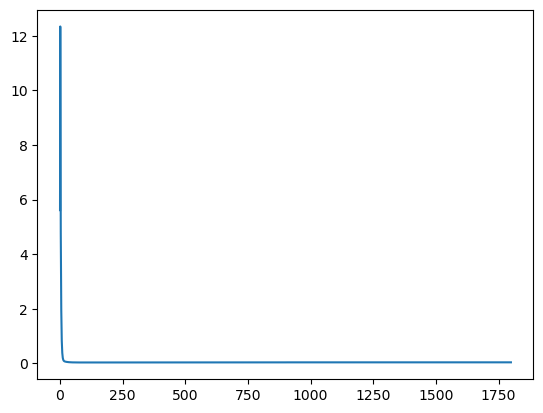

In [6]:
#Строим график ошибки MSE на тестовом множестве от параметра регуляризации
from matplotlib import pyplot as plt
plt.plot(CC)
plt.show()

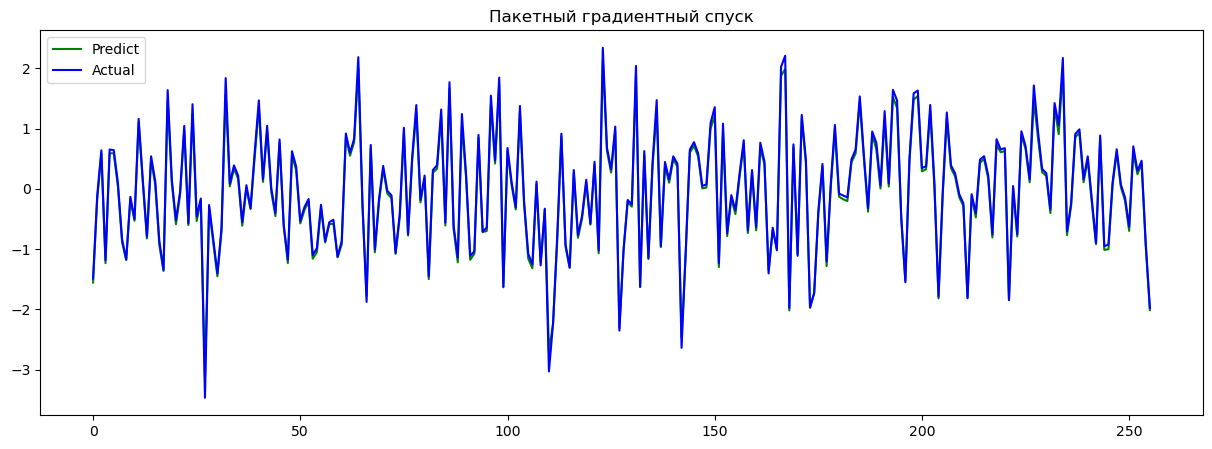

SMAPE ошибка : 8.865171250168462
NRMSE ошибка : -5.656969685296554e+17


In [7]:
#Построим зависимость экспоненциального скользящего среднего эмпирического риска на тренировочном множестве для градиентного спуска
Y_predict = np.dot(W_trained,X_MSE_test) + b_trained
X_axis = [i for i in range(256)]
plt.figure(figsize=(15,5))
plt.plot(X_axis,Y_predict[0],'g',label = 'Predict')
plt.plot(X_axis,Y_MSE_test,'b', label = 'Actual')
plt.legend(loc="upper left")
plt.title("Пакетный градиентный спуск")
plt.show()

R21 = SMAPE(Y_predict[0],Y_MSE_test)
R22 = NRMSE(Y_predict[0],Y_MSE_test)
#Оценка метода на тестовом множестве данных при помощи NRMSE и SMAPE.
print(f'SMAPE ошибка : {SMAPE(Y_predict[0],Y_MSE_test)}')
print(f'NRMSE ошибка : {NRMSE(Y_predict[0],Y_MSE_test)}')

## Градиентный спуск используя SMAPE

In [8]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

Q = 64
X_Batches, Y_Batches, X_rem, Y_rem, number_of_batches = Mini_Batches(Q,X_train,Y_train)

def GD(X_train,Y_train,number_of_batches,number_of_itr,alfa,beta,lambd,Flag):
    W = np.random.randn(1,M)*(1/(2*N))
    b = 0
    CC = []
    for j in tqdm_notebook(range(number_of_itr)):
        cost = 0
        Vdw = 0
        Vdb = 0
        for i in range(number_of_batches):
            if i == number_of_batches - 1:
                X = X_rem
                Y = Y_rem
            else:
                X = X_Batches[i]
                Y = Y_Batches[i]
            Z = np.dot(W,X)
            dy = Z-Y
            ss = np.abs(Z)+np.abs(Y)
            n1 = np.sign(dy)*ss - np.sign(Z)*dy
            dL = n1/(ss**2)
            dw = np.dot(dL,X.T)/Q
            db = np.sum(dL,axis = 1, keepdims=True)/Q
            Vdw = beta*Vdw + (1-beta)*dw
            Vdb = beta*Vdb + (1-beta)*db
            W = W - alfa*(Vdw + lambd)
            b = b - alfa*(Vdb + lambd)
            cost += np.sum(np.abs(dy)/ss)
        CC.append(cost)
        if Flag == True and j%100 == 0:
            alfa = 0.99*alfa
            print(f'Итерация {j} ошибка составляет {cost}')
    return W, b, CC
W_trained, b_trained, CC = GD(X_train,Y_train,number_of_batches,1400,0.009,0.9,0,True)

Итерация 0 ошибка составляет 854.5844373785038
Итерация 100 ошибка составляет 13.189870349482723
Итерация 200 ошибка составляет 4.066522324573949
Итерация 300 ошибка составляет 6.057095428924798
Итерация 400 ошибка составляет 4.717102803383905
Итерация 500 ошибка составляет 5.846124241837322
Итерация 600 ошибка составляет 4.15990032234047
Итерация 700 ошибка составляет 4.024968380582884
Итерация 800 ошибка составляет 2.0712394125124973
Итерация 900 ошибка составляет 3.9580353689680505
Итерация 1000 ошибка составляет 2.8501899910349144
Итерация 1100 ошибка составляет 4.5365142546001715
Итерация 1200 ошибка составляет 3.8618912456035326
Итерация 1300 ошибка составляет 5.445413358483719



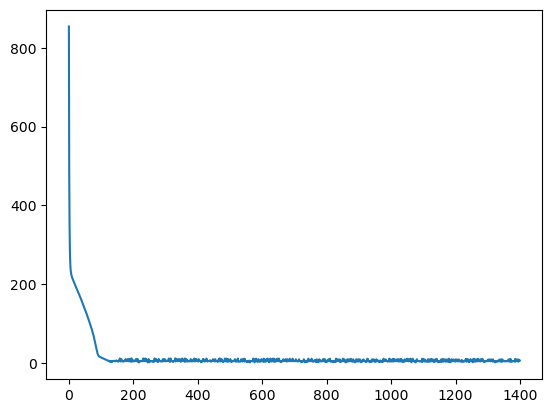

In [9]:
#Строим график ошибки SMAPE на тестовом множестве от параметра регуляризации
from matplotlib import pyplot as plt
plt.plot(CC)
plt.show()

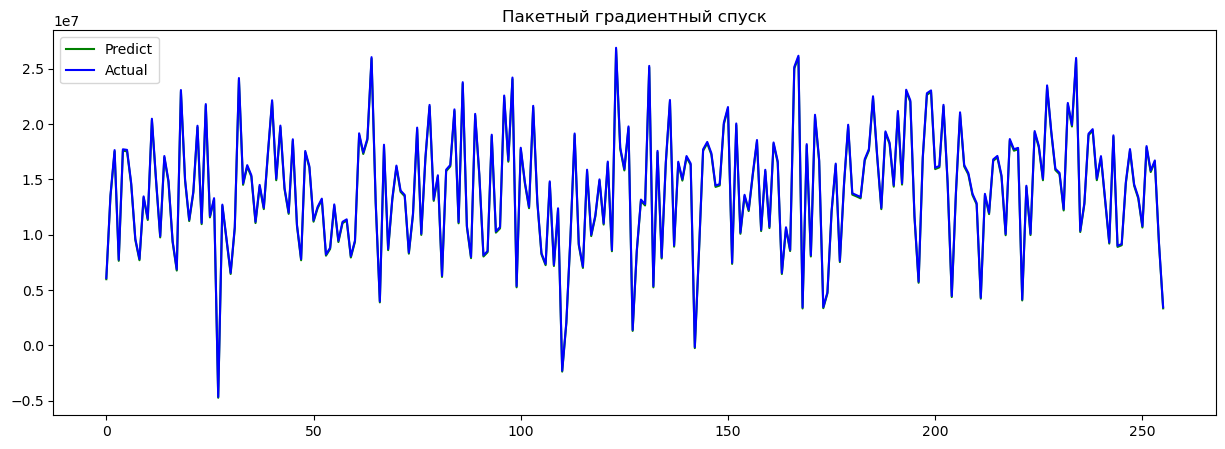

SMAPE ошибка : 0.5920303859743328
NRMSE ошибка : 0.8669865198305448


In [10]:
#Построим зависимость экспоненциального скользящего среднего эмпирического риска на тренировочном множестве для градиентного спуска
Y_predict = np.dot(W_trained,X_test) + b_trained

X_axis = [i for i in range(256)]
plt.figure(figsize=(15,5))
plt.plot(X_axis,Y_predict[0],'g',label = 'Predict')
plt.plot(X_axis,Y_test,'b', label = 'Actual')
plt.legend(loc="upper left")
plt.title("Пакетный градиентный спуск")
plt.show()

R31 = SMAPE(Y_predict[0],Y_test)
R32 = NRMSE(Y_predict[0],Y_test)

#Оценка метода на тестовом множестве данных при помощи NRMSE и SMAPE.
print(f'SMAPE ошибка : {SMAPE(Y_predict[0],Y_test)}')
print(f'NRMSE ошибка : {NRMSE(Y_predict[0],Y_test)}')

## Градиентный спуск (обычный)

In [11]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

W = np.random.randn(1,M)*(1/(2*N))
b = 0
CC = []
alfa = 0.7
beta = 0.99
Vdw = 0
Vdb = 0
print(np.std(X_temp))
lambd = 0
for j in tqdm_notebook(range(1750)):
    Z = np.dot(W,X_train)
    dy = Z-Y_train
    ss = np.abs(Z)+np.abs(Y_train)
    n1 = np.sign(dy)*ss - np.sign(Z)*dy
    dL = n1/(ss**2)
    dw = np.dot(dL,X_train.T)/N
    db = np.sum(dL,axis = 1, keepdims=True)/N
    Vdw = beta*Vdw + (1-beta)*dw
    Vdb = beta*Vdb + (1-beta)*db
    W = (1-alfa*lambd)*W - alfa*Vdw
    b = (1-alfa*lambd)*b - alfa*Vdb
    cost = np.sum(np.abs(dy)/ss)
    CC.append(cost)
    if j%100 == 0:
        alfa = 0.99*alfa
        print(f'Итерация {j} ошибка составляет {cost}')



1464151.3745249868


Итерация 0 ошибка составляет 1163.940538080497
Итерация 100 ошибка составляет 281.7630590184606
Итерация 200 ошибка составляет 174.8359876531821
Итерация 300 ошибка составляет 95.64113860568926
Итерация 400 ошибка составляет 33.570140814747724
Итерация 500 ошибка составляет 15.50304040620913
Итерация 600 ошибка составляет 36.83150679066861
Итерация 700 ошибка составляет 25.239358597190254
Итерация 800 ошибка составляет 17.619071992280194
Итерация 900 ошибка составляет 7.845806837245494
Итерация 1000 ошибка составляет 41.89582555219283
Итерация 1100 ошибка составляет 51.16040525124262
Итерация 1200 ошибка составляет 33.38778062705439
Итерация 1300 ошибка составляет 29.933995904819756
Итерация 1400 ошибка составляет 29.1624441991042
Итерация 1500 ошибка составляет 70.15125794186909
Итерация 1600 ошибка составляет 5.924122673354107
Итерация 1700 ошибка составляет 15.69552166233047



18.855013995815057


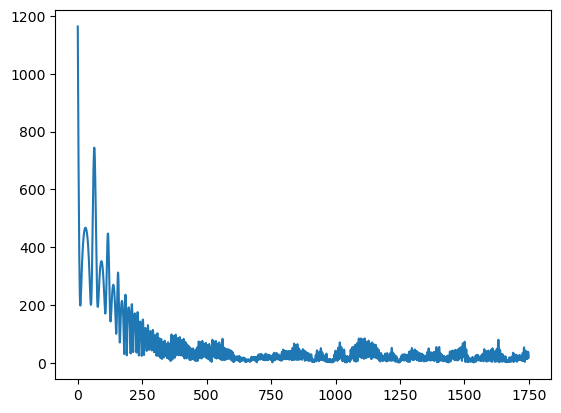

In [12]:
from matplotlib import pyplot as plt
print(cost)
plt.plot(CC)
plt.show()

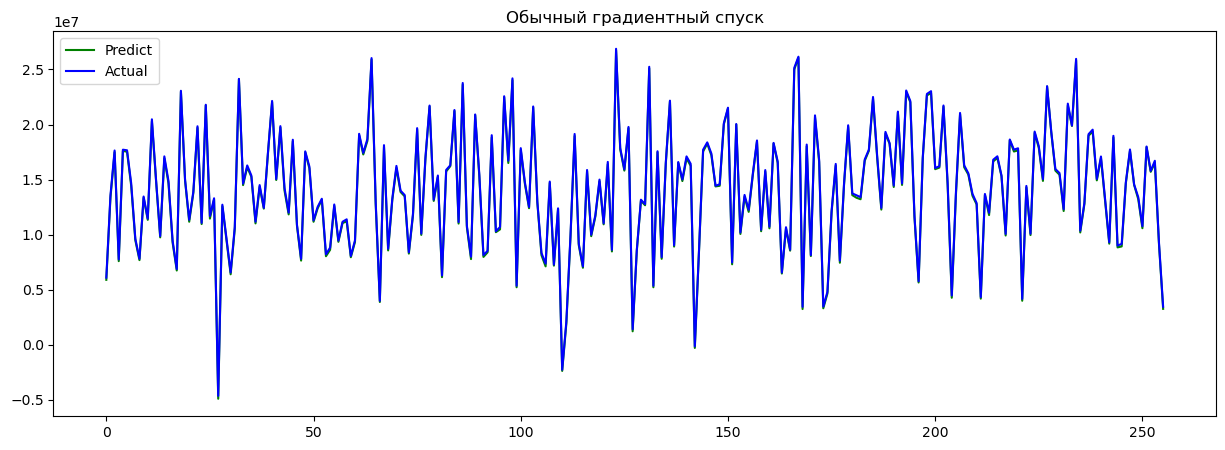

SMAPE ошибка : 0.7568955416677171
NRMSE ошибка : 1.0124931223238476


In [13]:
Y_predict = np.dot(W,X_test) + b

X_axis = [i for i in range(256)]
plt.figure(figsize=(15,5))
plt.plot(X_axis,Y_predict[0],'g',label = 'Predict')
plt.plot(X_axis,Y_test,'b', label = 'Actual')
plt.legend(loc="upper left")
plt.title('Обычный градиентный спуск')
plt.show()

print(f'SMAPE ошибка : {SMAPE(Y_predict[0],Y_test)}')
print(f'NRMSE ошибка : {NRMSE(Y_predict[0],Y_test)}')

# Поиск наилучших гиперпараметров

## Выбор скорости обучения (альфа)

In [14]:
#Выбираем лучшее значение переменной альфа, чтобы уменьшить величину ошибки
r = [-5*np.random.rand() for i in range(10)]
lr = np.power(10,r)
lr = sorted(lr)
print(lr)
Ans = np.array([])
for i in range(10):
    W_trained, b_trained, CC = GD(X_train,Y_train,number_of_batches,1200,lr[i],0,0,False)
    Y_predict = np.dot(W_trained,X_test) + b_trained
    DEF = SMAPE(Y_predict[0],Y_test)
    print(f'SMAPE ошибка при альфа = {lr[i]} составляет : {DEF}')
    Ans = np.append(Ans,DEF)

[2.7422586154218183e-05, 9.152663809911874e-05, 9.779127166243303e-05, 0.001530343499976611, 0.002350113922457996, 0.012957143789993178, 0.024546224337950125, 0.23323326370133102, 0.5922573904895194, 0.632977551681613]



SMAPE ошибка при альфа = 2.7422586154218183e-05 составляет : 28.546076976663475



SMAPE ошибка при альфа = 9.152663809911874e-05 составляет : 14.82063317679015



SMAPE ошибка при альфа = 9.779127166243303e-05 составляет : 14.609629386009782



SMAPE ошибка при альфа = 0.001530343499976611 составляет : 0.05057776819329249



SMAPE ошибка при альфа = 0.002350113922457996 составляет : 0.016567263616067307



SMAPE ошибка при альфа = 0.012957143789993178 составляет : 0.07138307741072442



SMAPE ошибка при альфа = 0.024546224337950125 составляет : 2.113129560005307



SMAPE ошибка при альфа = 0.23323326370133102 составляет : 12.435863797341337



SMAPE ошибка при альфа = 0.5922573904895194 составляет : 30.23887312819713



SMAPE ошибка при альфа = 0.632977551681613 составляет : 37.50227878514825


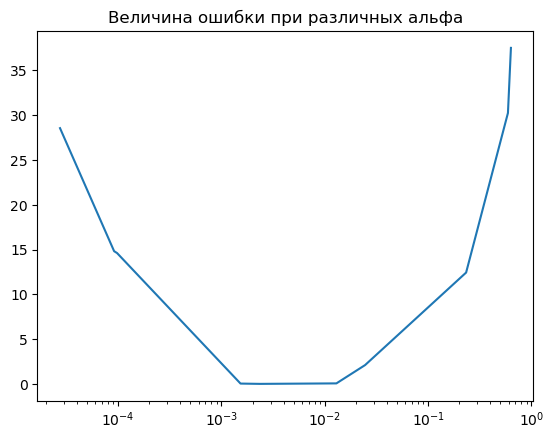

In [15]:
#Значение ошибки (SMAPE) при различных альфа
plt.xscale("log")
plt.plot(lr,Ans)
plt.title("Величина ошибки при различных альфа")
plt.show()

## Выбор параметра регулязации (лямбда)

In [16]:
#Выбираем лучшее значение переменной лямбда, чтобы избежать перееобучения
r = np.array([-7.0,-6,-5,-4,-3,-2,-1])
lr = np.power(10,r)
lr = sorted(lr)
print(lr)
Ans = np.array([])
for i in range(7):
    W_trained, b_trained, CC = GD(X_train,Y_train,number_of_batches,1200,0.009,0.9,lr[i],False)
    Y_predict = np.dot(W_trained,X_test) + b_trained
    DEF = SMAPE(Y_predict[0],Y_test)
    print(f'SMAPE ошибка при лямбда = {lr[i]} составляет : {DEF}')
    Ans = np.append(Ans,DEF)

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]



SMAPE ошибка при лямбда = 1e-07 составляет : 0.42943826469498747



SMAPE ошибка при лямбда = 1e-06 составляет : 0.7980324793500758



SMAPE ошибка при лямбда = 1e-05 составляет : 0.3688386732877353



SMAPE ошибка при лямбда = 0.0001 составляет : 0.15281040535094742



SMAPE ошибка при лямбда = 0.001 составляет : 0.6864382750500372



SMAPE ошибка при лямбда = 0.01 составляет : 0.4391687733909213



SMAPE ошибка при лямбда = 0.1 составляет : 70.1909050560579


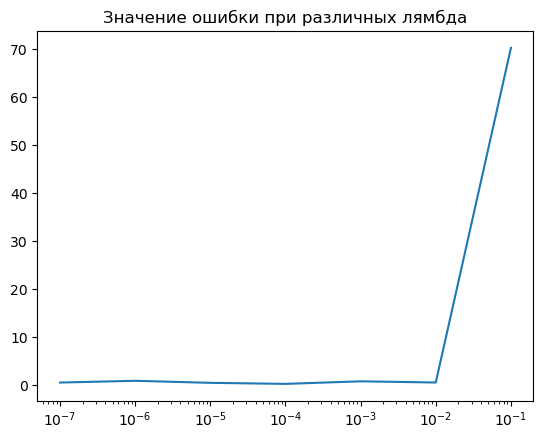

In [17]:
#Значение ошибки (SMAPE) при различных лямбда
plt.xscale("log")
plt.plot(lr,Ans)
plt.title("Значение ошибки при различных лямбда")
plt.show()

## Сравнение алгоритмов

0.0009818243215296636 8.865171250168462 0.5920303859743328


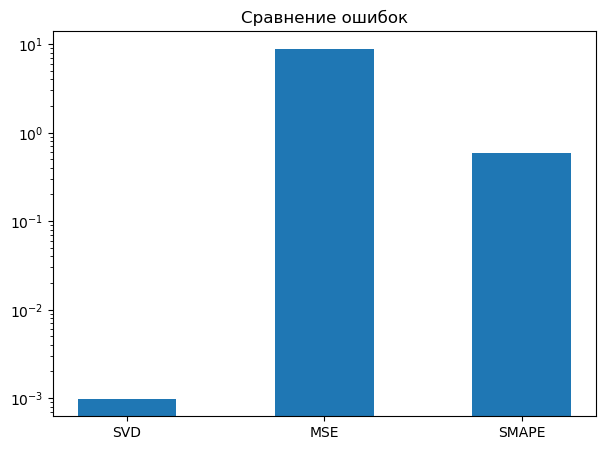

In [18]:
#Сравним различные функции ошибки
plt.figure(figsize=(7,5))
NN = ['SVD','MSE','SMAPE']
SMAPE_Error = [R11,R21,R31]
print(R11,R21,R31)
plt.bar(NN,SMAPE_Error,width = 0.5)
plt.yscale("log")
plt.title("Сравнение ошибок")
plt.show()